# Running Scarlet on Strong Lensed Systems from Twinkles

<br>Owner(s): **Bryce Kalmbach** ([@jbkalmbach](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@jbkalmbach))
<br>Last Verified to Run: **2019-06-28**
<br>Verified Stack Release: **v17.0.1**

This notebook shows how to use the Truth information for the Twinkles dataset to find and display postage stamps of simulated strongly lensed AGN systems. It will then demonstrate debelending using *scarlet* on these postage stamps.

### Learning Objectives:

After working through this tutorial you should be able to: 
1. Find simulated strongly lensed systems in Twinkles data;
2. Display the postage stamps of the lensed Twinkles systems;
3. Run the *scarlet* deblending algorithm on the postage stamps.

For more information on learning how to use *scarlet* see the [tutorial notebook](scarlet_tutorial.ipynb) in this same folder. This notebook also uses methods from [A Guided Tour of LSST Calexps](../Basics/Calexp_guided_tour.ipynb) to load calexps and display postage stamps.

### Logistics
This notebook is intended to be runnable on `lsst-lspdev.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

## Set-up

In [1]:
import numpy as np
import pandas as pd
import lsst.afw.display as afw_display
from lsst.daf.persistence import Butler

from lsst.afw.geom import SpherePoint, Angle, degrees
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
%matplotlib inline

## Find Twinkles Lensed AGN

In [2]:
# Get twinkles object locations
twinkles_lens_truth = pd.read_csv('/project/shared/data/Twinkles_subset/truth/sprinkled_lens_230_J2000.txt')
twinkles_agn_truth = pd.read_csv('/project/shared/data/Twinkles_subset/truth/sprinkled_agn_230_J2000.txt')

In [3]:
twinkles_lens_truth.head()

,galid,ra,dec,mag,z,majorAxis,minorAxis,positionAngle
0,21393434,53.053595,-27.702812,17.830105,0.184,0.000008,0.000006,0.992165
1,23359514,53.084649,-27.707132,19.934687,0.302,0.000004,0.000004,-1.212659
2,48583706,52.785357,-27.304809,20.538992,0.566,0.000008,0.000005,-2.466347
3,55131162,52.969790,-27.421952,19.489100,0.362,0.000010,0.000006,0.828111
4,78559258,52.899903,-27.282086,20.068371,0.378,0.000003,0.000003,1.905971


In [4]:
datadir = '/project/shared/data/Twinkles_subset/output_data_v2/'
butler = Butler(datadir)

In [5]:
dataId = {'filter': 'r', 'raft': '2,2', 'sensor': '1,1', 'visit': 235}
calexp = butler.get('calexp', **dataId)

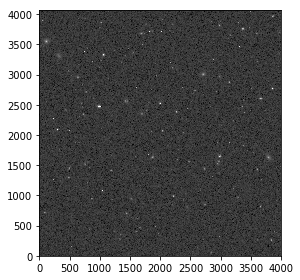

In [6]:
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale('asinh', 'zscale')
display1.mtv(calexp.image)

In [7]:
wcs = calexp.getWcs()
wcs

In [8]:
ra, dec = wcs.pixelToSky(1000.0, 1000.0)

In [9]:
# Identify systems within .03 degrees of the specified ra,dec
np.where(((np.abs(ra.asDegrees() - twinkles_lens_truth['ra'].values) < 0.03) &
          (np.abs(dec.asDegrees() - twinkles_lens_truth['dec'].values) < 0.03)))

(array([ 16,  54,  73, 190]),)

In [27]:
# Calculate pixel values for lensing galaxy
wcs.skyToPixel(SpherePoint(Angle(float(twinkles_lens_truth.iloc[73]['ra']), degrees),
                           Angle(float(twinkles_lens_truth.iloc[73]['dec']), degrees)))

Point2D(1131.350671, 1054.887624)

In [29]:
bbox = afwGeom.Box2I()
bbox.include(afwGeom.Point2I(761, 1521))
cutout = calexp[bbox]

Now we want to match up the AGN that go with this lensing galaxy so we match on the `galid`.

In [30]:
twinkles_lens_truth.iloc[73]['galid']

2835515418.0

In [31]:
twinkles_sys = twinkles_agn_truth.query('lens_galids == 2835515418')

In [32]:
twinkles_sys

,galid,ra,dec,mag,sed_name,z,twinkles_system,twinkles_img_num,lens_galids
176,28355155324956,52.936374,-27.405727,22.553032,agnSED/agn.spec.gz,1.97,343,0,2835515418
177,28355155325980,52.935829,-27.405592,23.412711,agnSED/agn.spec.gz,1.97,343,1,2835515418


In [33]:
wcs.skyToPixel(SpherePoint(float(twinkles_agn_truth.iloc[177]['ra']),
                           float(twinkles_agn_truth.iloc[177]['dec']), degrees))

Point2D(1127.647366, 1053.185198)

## Display a Twinkles System

Text(-7.85707,0.5,'Y Pixels')

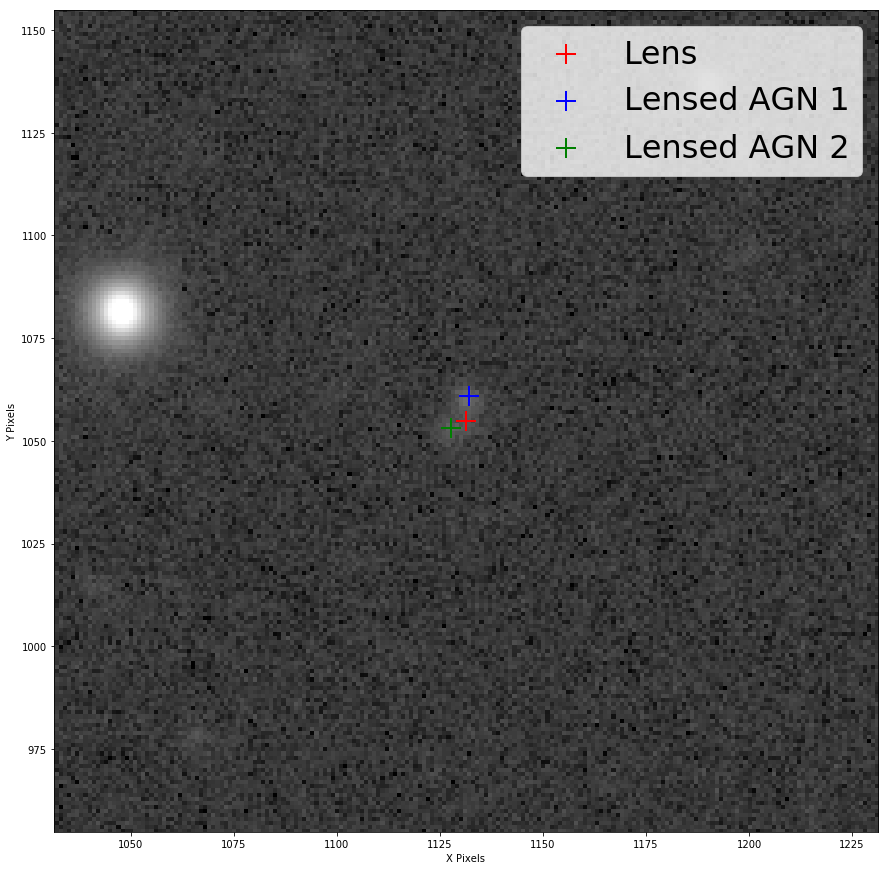

In [39]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale('asinh', 'zscale')
display1.mtv(calexp.image)
display1.zoom(40)
display1.pan(1131.350671, 1054.887624)
plt.scatter(1131.350671, 1054.887624, c='r', marker='+', label='Lens', s=400, lw=2)
plt.scatter(1132.180802, 1061.002843, c='b', marker='+', label='Lensed AGN 1', s=400, lw=2)
plt.scatter(1127.647366, 1053.185198, c='g', marker='+', label='Lensed AGN 2', s=400, lw=2)
plt.legend(fontsize=32)
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

(1031.350671, 1231.350671)

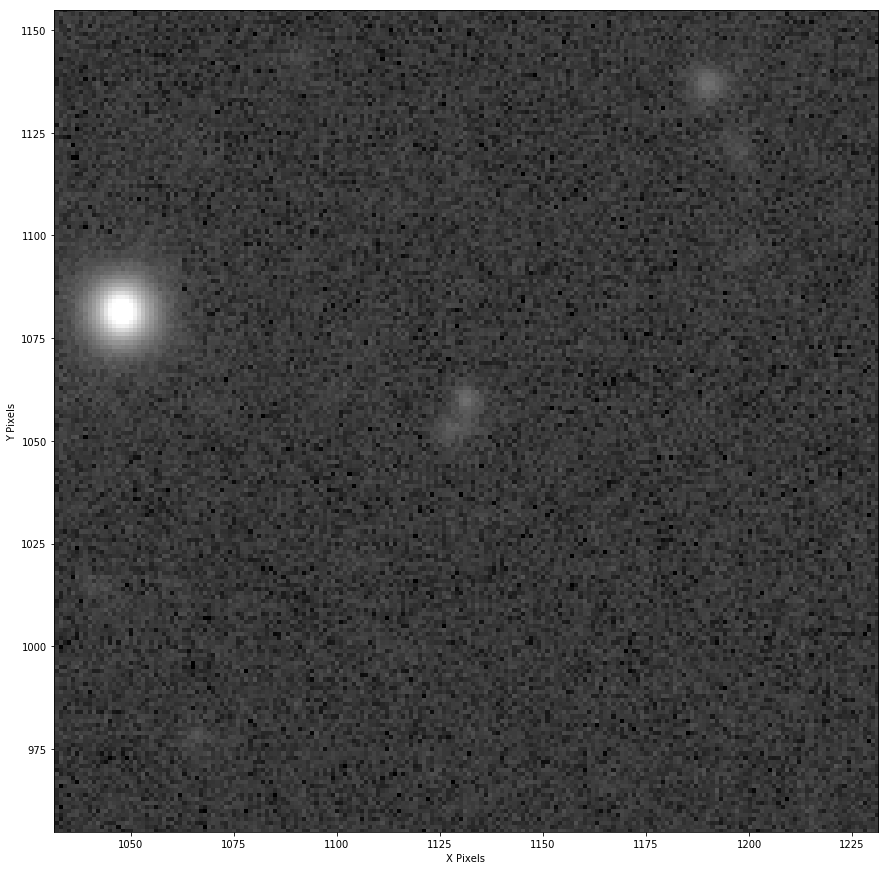

In [35]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale('asinh', 'zscale')
display1.mtv(calexp.image)
display1.zoom(40)
display1.pan(1131.350671, 1054.887624)
#plt.scatter(1131.350671, 1054.887624, c='r', marker='+', label='Lens')
#plt.scatter(1132.180802, 1061.002843, c='b', marker='+', label='Lensed AGN 1')
#plt.scatter(1127.647366, 1053.185198, c='g', marker='+', label='Lensed AGN 2')
#plt.legend()
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.xlim()

### Run _Scarlet_ deblender